# Tanzania Tourism EDA + MODELLING
* Can you use tourism survey data and ML to classify the range of expenditures a tourist spends in Tanzania 


### Import necessary Libraries and load the data
Libraries help reduce coding errors, make programmers more efficient, and make software smaller in size (and lines of code). Instead of writing long lines of code to accomplish a common task, coders can simply call upon a library – often with a single line of code – to perform that task instead.

In [1]:
import pandas as pd #A fast, powerful, flexible and easy to use open source data analysis and manipulation tool
import numpy as np # Library for working with arrays

# creating visualizations in python
import matplotlib.pyplot as plt 
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# import catboost as catt
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedStratifiedKFold,train_test_split

pd.options.display.max_rows = 2200
import gc 

In [2]:
##where your train and test files are located, 
##don't change this if you are running this notebook om the same folder that the data is
path = "./"

In [3]:
#import data
train = pd.read_csv(path+'Train.csv')
test=  pd.read_csv(path+'Test.csv')

submission = pd.read_csv(path+'SampleSubmission.csv')

In [4]:
# How to check the number of rows and columns in a dataset
train.shape,test.shape

((18506, 21), (6169, 20))

In [5]:
# How to see the first 5 rows in a dataset
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [6]:
## List all the columns available
train.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category'],
      dtype='object')

In [7]:
## This is what you are trying to predict 
train.cost_category.unique()

array(['High Cost', 'Higher Cost', 'Lower Cost', 'Normal Cost',
       'Low Cost', 'Highest Cost'], dtype=object)

### DATATYPE DESCRIPTION AND  STATISTICAL INFORMATION

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

#### We can see a mixture of object columns and int ones with object columns being the majority ones

In [9]:
# describe the continouos variables
train.describe()

,total_female,total_male,night_mainland,night_zanzibar
count,18504.000000,18500.000000,18506.000000,18506.000000
mean,0.936230,0.998757,9.141576,2.493516
std,1.215582,1.173177,14.127449,5.275156
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,3.000000,0.000000
50%,1.000000,1.000000,6.000000,0.000000
75%,1.000000,1.000000,11.000000,4.000000
max,49.000000,58.000000,365.000000,240.000000


#### The max is so far away from the 75th percentile in almost all cols, Are those outliers??  Can you deal with them?
 - drop them
 - cap them - research them

## Missing values

In [10]:
train.isnull().sum() * 100/len(train)

Tour_ID                  0.000000
country                  0.000000
age_group                0.000000
travel_with              5.808927
total_female             0.010807
total_male               0.032422
purpose                  0.000000
main_activity            0.000000
info_source              0.000000
tour_arrangement         0.000000
package_transport_int    0.000000
package_accomodation     0.000000
package_food             0.000000
package_transport_tz     0.000000
package_sightseeing      0.000000
package_guided_tour      0.000000
package_insurance        0.000000
night_mainland           0.000000
night_zanzibar           0.000000
first_trip_tz            0.000000
cost_category            0.000000
dtype: float64

In [11]:
len(train)

18506

In [12]:
#check for missing values
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
Tour_ID,Tour_ID,0.000000
country,country,0.000000
age_group,age_group,0.000000
travel_with,travel_with,5.808927
total_female,total_female,0.010807
total_male,total_male,0.032422
purpose,purpose,0.000000
main_activity,main_activity,0.000000
info_source,info_source,0.000000
tour_arrangement,tour_arrangement,0.000000


#### Only few columns with missing values which are travel_with with 5%, total_female 0.01%, total_male 0.03%. There are many ways to feeel this columns, You've to try all and evaluate which is best
 - Numerical : mean, median, high arbitrary value(-9999)
 - Categorical : mode, unknown feature

In [13]:
train.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64

In [14]:
# create a list of both categorical and numerical columns
cat_columns = [col for col in train.select_dtypes('object').columns]

num_columns = [col for col in train.select_dtypes(['int', 'float']).columns]

### Find a way to fill the missing values

In [15]:
# check unique values in travel_with
train.travel_with.unique()

array(['With Children', 'With Spouse', 'With Spouse and Children',
       'Alone', nan, 'With Other Friends/Relatives'], dtype=object)

In [16]:
train['travel_with'].mode()[0]

'Alone'

In [17]:
# fill in the missing values in travel_with column
train['travel_with'] = train['travel_with'].fillna(train['travel_with'].mode()[0])

In [18]:
# fill in missing values of total female or male with either mean or median
train['total_female'] = train['total_female'].fillna(train['total_female'].median())
train['total_male'] = train['total_male'].fillna(train['total_male'].median())

In [19]:
# recheck if we have missing values
train.isnull().sum()

Tour_ID                  0
country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
first_trip_tz            0
cost_category            0
dtype: int64

## Categorical Data

In [20]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

Tour_ID                  18506
country                    131
age_group                    5
travel_with                  5
total_female                24
total_male                  24
purpose                      8
main_activity               10
info_source                  8
tour_arrangement             2
package_transport_int        2
package_accomodation         2
package_food                 2
package_transport_tz         2
package_sightseeing          2
package_guided_tour          2
package_insurance            2
night_mainland             110
night_zanzibar              60
first_trip_tz                2
cost_category                6
dtype: int64

### EXPLORATORY DATA ANALYSIS

### Age Group

In [21]:
train['age_group'].value_counts(normalize=True)

25-44    0.488868
45-64    0.305198
18-24    0.120069
65+      0.079272
<18      0.006592
Name: age_group, dtype: float64

25-44    9047
45-64    5648
18-24    2222
65+      1467
<18       122
Name: age_group, dtype: int64


Text(0.5, 0, 'age_group')

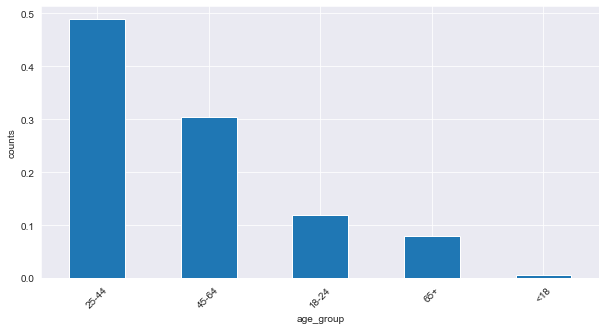

In [22]:
print(train['age_group'].value_counts())
plt.figure(figsize=(10,5))
train['age_group'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xticks(rotation=45)
plt.xlabel('age_group')

#### 25-44 age group are the majority since they are in the working class and have freedom+ energy.This feature is in contention for a StratifiedGroupKFold as per the description

### Travel With

Alone                           8665
With Spouse                     4842
With Other Friends/Relatives    3268
With Spouse and Children        1193
With Children                    538
Name: travel_with, dtype: int64


Text(0.5, 0, 'travel_with')

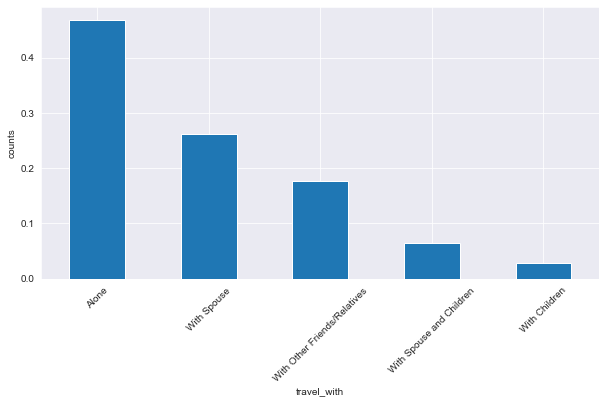

In [23]:
print(train['travel_with'].value_counts())
plt.figure(figsize=(10,5))
train['travel_with'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xticks(rotation=45)
plt.xlabel('travel_with')

### Purpose

#### Alone the majority, followed by spouse which is understandable

Leisure and Holidays              11755
Visiting Friends and Relatives     2304
Business                           2297
Meetings and Conference            1179
Volunteering                        438
Other                               326
Scientific and Academic             198
Medical                               9
Name: purpose, dtype: int64


Text(0.5, 0, 'purpose')

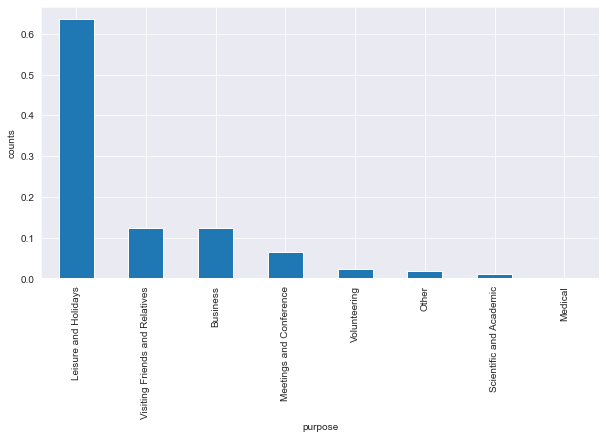

In [24]:
print(train['purpose'].value_counts())
plt.figure(figsize=(10,5))
train['purpose'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('purpose')

#### Understandable with majority being here for leisure and holiday. This feature is also in contention for a Group KFold as per the description

### Main Activity

In [25]:
train['wildlife_tourism'] = train['main_activity'].values[1] + train['main_activity'].values[2]

Widlife Tourism             5988
Beach Tourism               4172
Wildlife Tourism            2283
Conference Tourism          1920
Hunting Tourism             1712
Cultural Tourism            1444
Mountain Climbing            529
Business                     280
Bird Tourism                 144
Diving and Sport Fishing      34
Name: main_activity, dtype: int64


Text(0.5, 0, 'main_activity')

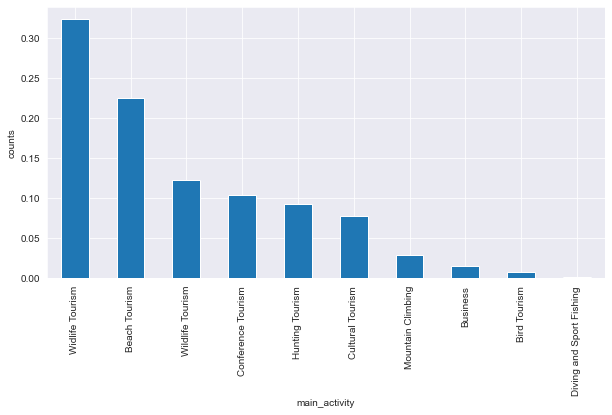

In [26]:
print(train['main_activity'].value_counts())
plt.figure(figsize=(10,5))
train['main_activity'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('main_activity')

In [27]:
# train.columns

#### Wildlife Tourism is the majority one, since AFrica is well know for Tourism

 ### Info Source

Travel agent, tour operator        8005
Friends, relatives                 6077
Others                             1368
Newspaper, magazines, brochures    1301
Radio, TV, Web                     1223
Trade fair                          243
Tanzania Mission Abroad             197
Inflight magazines                   92
Name: info_source, dtype: int64


Text(0.5, 0, 'info_source')

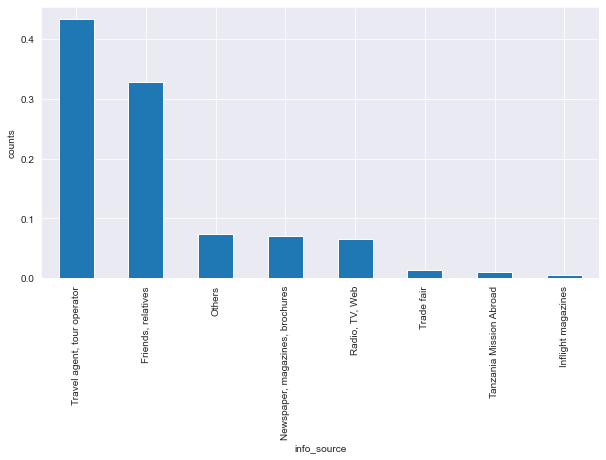

In [28]:
print(train['info_source'].value_counts())
plt.figure(figsize=(10,5))
train['info_source'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('info_source')

#### Travel agencies are the leading source of info, which is understandable followed by friends 

### Tour Arrangement

Package Tour    9295
Independent     9211
Name: tour_arrangement, dtype: int64


Text(0.5, 0, 'tour_arrangement')

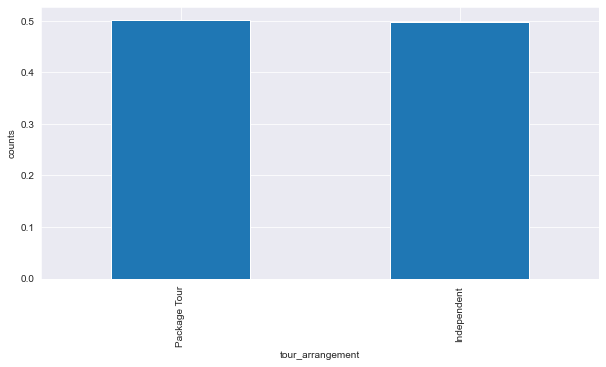

In [29]:

print(train['tour_arrangement'].value_counts())
plt.figure(figsize=(10,5))
train['tour_arrangement'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('tour_arrangement')

#### Equal distribution here

### Package Transport Int

No     12238
Yes     6268
Name: package_transport_int, dtype: int64


Text(0.5, 0, 'package_transport_int')

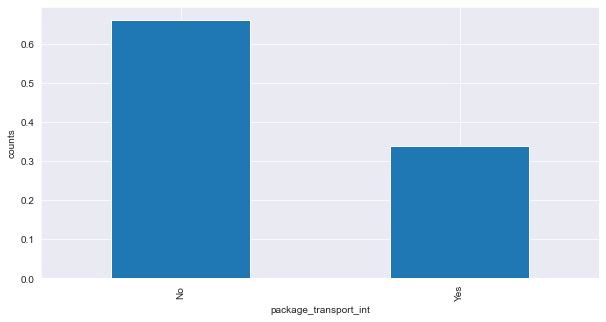

In [30]:

print(train['package_transport_int'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_int'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_int')

#### Majority the international transport wasn't provided

### Package Accomodation

No     9541
Yes    8965
Name: package_accomodation, dtype: int64


Text(0.5, 0, 'package_accomodation')

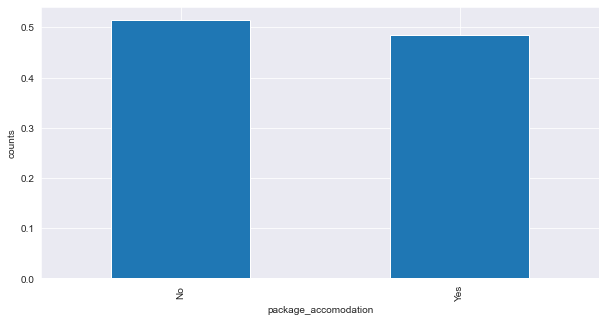

In [31]:

print(train['package_accomodation'].value_counts())
plt.figure(figsize=(10,5))
train['package_accomodation'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_accomodation')

#### Majority The accomodation package was not provided although equal distribution

### Package Food

No     10143
Yes     8363
Name: package_food, dtype: int64


Text(0.5, 0, 'package_food')

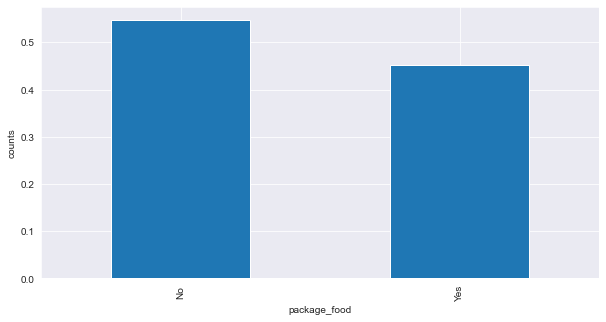

In [32]:

print(train['package_food'].value_counts())
plt.figure(figsize=(10,5))
train['package_food'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_food')

#### Majority Package food wasnt provided

### Package Transport TZ

No     10873
Yes     7633
Name: package_transport_tz, dtype: int64


Text(0.5, 0, 'package_transport_tz')

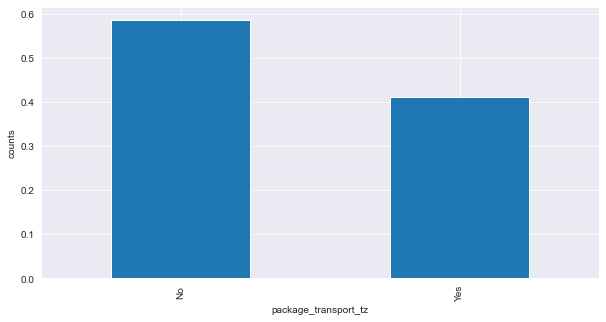

In [33]:

print(train['package_transport_tz'].value_counts())
plt.figure(figsize=(10,5))
train['package_transport_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_transport_tz')

#### Majority Tanzania transport package was not provided

### Package SightSeeing

No     12786
Yes     5720
Name: package_sightseeing, dtype: int64


Text(0.5, 0, 'package_sightseeing')

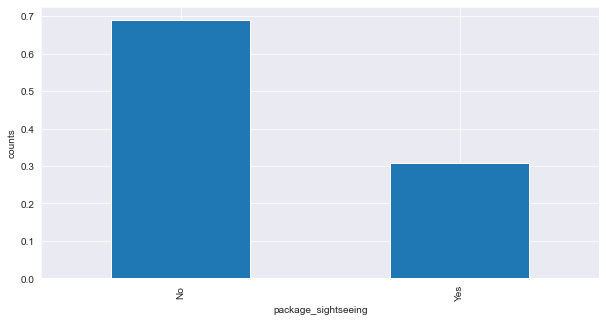

In [34]:

print(train['package_sightseeing'].value_counts())
plt.figure(figsize=(10,5))
train['package_sightseeing'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_sightseeing')

#### Majority Package_sightseeing was not provided

### Package Guided Tour

No     12447
Yes     6059
Name: package_guided_tour, dtype: int64


Text(0.5, 0, 'package_guided_tour')

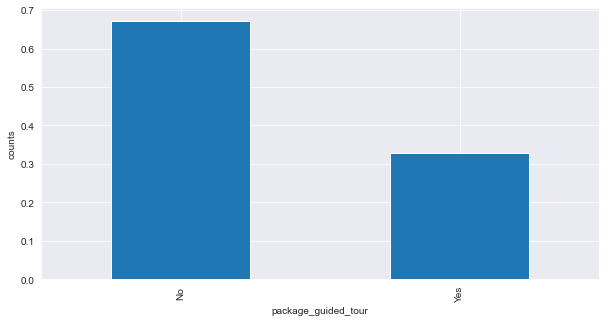

In [35]:

print(train['package_guided_tour'].value_counts())
plt.figure(figsize=(10,5))
train['package_guided_tour'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_guided_tour')

#### Majority package guided tour wasnt provided

### Package Insurance

No     15809
Yes     2697
Name: package_insurance, dtype: int64


Text(0.5, 0, 'package_insurance')

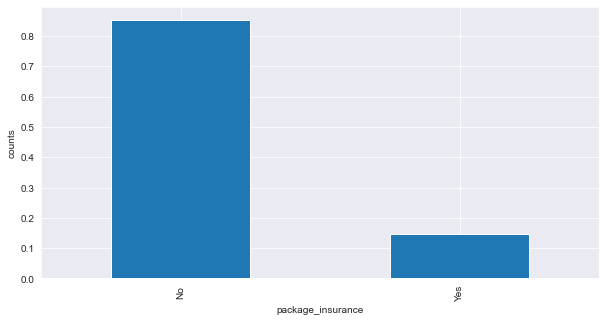

In [36]:

print(train['package_insurance'].value_counts())
plt.figure(figsize=(10,5))
train['package_insurance'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('package_insurance')

#### Majority Package_insurance was not provided and there is an imbalance between the two classes

### First Trip Tz

Yes    12737
No      5769
Name: first_trip_tz, dtype: int64


Text(0.5, 0, 'first_trip_tz')

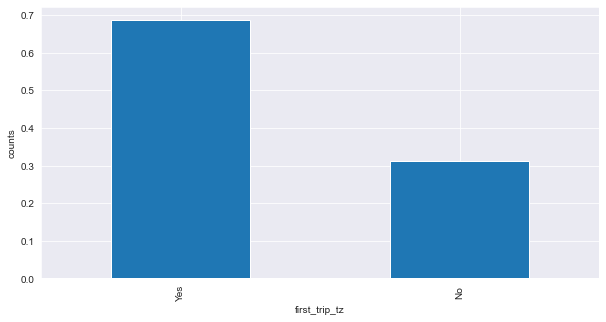

In [37]:

print(train['first_trip_tz'].value_counts())
plt.figure(figsize=(10,5))
train['first_trip_tz'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('first_trip_tz')

#### Majority it was their first time in Tanzania

### Now lets look at the Target class and see if its imbalanced

Normal Cost     5471
Higher Cost     4865
High Cost       3678
Lower Cost      2567
Low Cost        1566
Highest Cost     359
Name: cost_category, dtype: int64


Text(0.5, 0, 'Cost_Category')

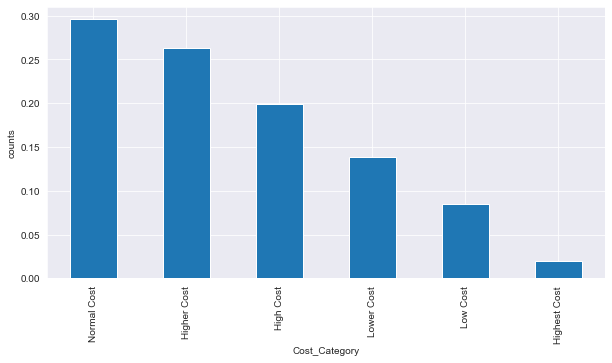

In [38]:
print(train['cost_category'].value_counts())
plt.figure(figsize=(10,5))
train['cost_category'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Cost_Category')

#### The last class is imbalanced so find a good cross validation scheme to deal with this or other ways
- use class weights
- smote

### Conclusion Categorical Features 
* Is the distribution of cat columns fair? if not what can you do? tip clustering
* do the distributions make sense ?
* Visualize also the numerical columns


In [39]:
# train.dtypes

In [40]:
# numerical columns
num = [col for col in train.select_dtypes(['float', 'int64'])]
num

['total_female', 'total_male', 'night_mainland', 'night_zanzibar']

### Total Female

Text(0.5, 0, 'Total female')

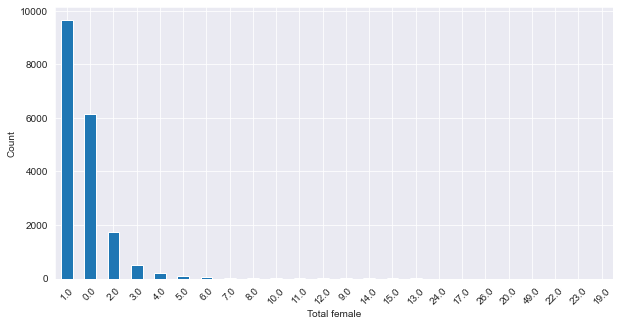

In [41]:
# print(train['total_female'].value_counts())
plt.figure(figsize=(10,5))
train['total_female'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Total female')

### Total male

Text(0.5, 0, 'Total male')

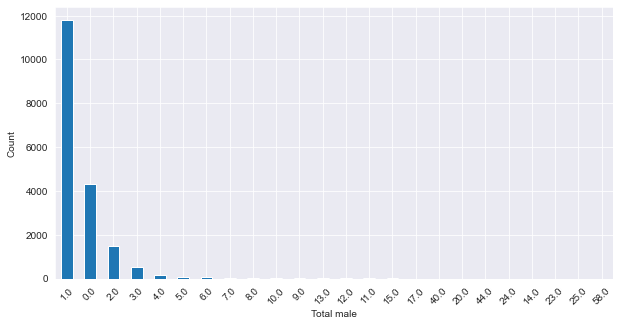

In [42]:
# print(train['total_male'].value_counts())
plt.figure(figsize=(10,5))
train['total_male'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Total male')

### Distribution of numerical columns

array([[<AxesSubplot:title={'center':'total_female'}>,
        <AxesSubplot:title={'center':'total_male'}>],
       [<AxesSubplot:title={'center':'night_mainland'}>,
        <AxesSubplot:title={'center':'night_zanzibar'}>]], dtype=object)

<Figure size 1440x1800 with 0 Axes>

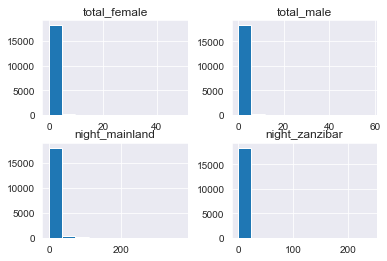

In [43]:
plt.figure(figsize = (20, 25))
train.hist()

In [44]:
cat_cols = [col for col in train.select_dtypes(['int64', 'float']).columns]
cat_cols

['total_female', 'total_male', 'night_mainland', 'night_zanzibar']

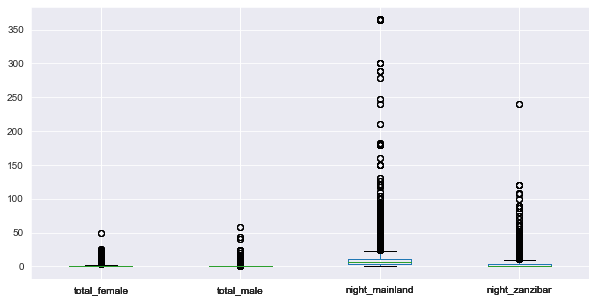

In [45]:
plt.figure(figsize = (10, 5))
for cat in cat_cols:
    train[cat_cols].boxplot()

In [46]:
train.head(3)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category,wildlife_tourism
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,No,No,0,7,Yes,High Cost,Wildlife TourismWidlife Tourism
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,No,No,No,0,7,Yes,High Cost,Wildlife TourismWidlife Tourism
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost,Wildlife TourismWidlife Tourism


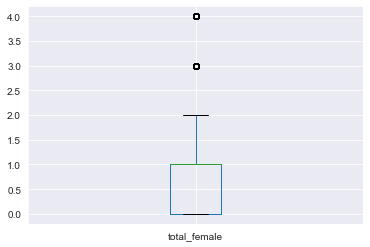

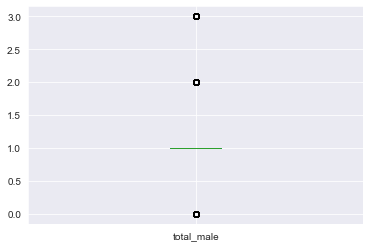

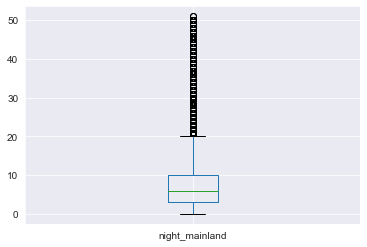

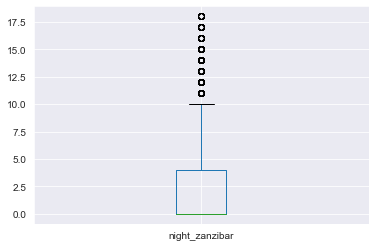

In [47]:
# remove outliers
for col in cat_cols:
    std = train[col].std()
    mean = train[col].mean()


    cut_off = std * 3

    lower, upper = mean - cut_off, mean + cut_off

    train = train[(train[col] < upper) & (train[col] > lower)]

    train[[col]].boxplot()
    plt.show()

##  Feature Engineering

In [48]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
# The reason we do this is because what transformations you use on train should also go in test data
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [49]:
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'wildlife_tourism'],
      dtype='object')

### Creatively come up with new features or cluster the existing ones
* This iss where the real work is in
* your creativity matters here?
* Read about how you can interact features to come up with new features e.g add the males and females to form a new column called total people

In [50]:
# print columns
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'wildlife_tourism'],
      dtype='object')

In [51]:
data['num_people'] = data['total_female'] + data['total_male']

data['packages'] =   data['package_transport_int'] + data['package_accomodation'] + data['package_food'] 
+ data['package_transport_tz'] + data['package_sightseeing'] + data['package_guided_tour']
+ data['tour_arrangement'] + data['package_insurance']

data['nights'] = data['night_mainland'] + data['night_zanzibar']

In [52]:
data['purpose_arrangement'] = data['purpose'] + data['tour_arrangement']
data['activity_arrangement'] = data['main_activity'] + data['tour_arrangement']

In [53]:
data['arrange_pack'] = data['tour_arrangement'] + data['packages']
# data['country_night'] = data['country'] + data['nights']

In [54]:
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'wildlife_tourism',
       'num_people', 'packages', 'nights', 'purpose_arrangement',
       'activity_arrangement', 'arrange_pack'],
      dtype='object')

In [55]:
# data = data.drop(columns = ['total_female', 'total_male',  
#                             'night_mainland', 'night_zanzibar'], axis=1)

In [56]:
data.head(3)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,night_zanzibar,first_trip_tz,cost_category,wildlife_tourism,num_people,packages,nights,purpose_arrangement,activity_arrangement,arrange_pack
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,7,Yes,High Cost,Wildlife TourismWidlife Tourism,2.0,YesYesYes,7,Visiting Friends and RelativesPackage Tour,Beach TourismPackage Tour,Package TourYesYesYes
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,7,Yes,High Cost,Wildlife TourismWidlife Tourism,2.0,YesYesYes,7,Leisure and HolidaysPackage Tour,Wildlife TourismPackage Tour,Package TourYesYesYes
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,6,Yes,Higher Cost,Wildlife TourismWidlife Tourism,2.0,YesYesYes,12,Leisure and HolidaysPackage Tour,Widlife TourismPackage Tour,Package TourYesYesYes


In [57]:
data.shape

(23734, 28)

### Pandas Get Dummies
* find the difference between this and label encoding

In [58]:
data.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'wildlife_tourism',
       'num_people', 'packages', 'nights', 'purpose_arrangement',
       'activity_arrangement', 'arrange_pack'],
      dtype='object')

In [59]:
data = pd.get_dummies(data, columns = [
 'age_group','main_activity','package_transport_int','first_trip_tz', 'arrange_pack', 'activity_arrangement'
])
data.head(3)

,Tour_ID,country,travel_with,total_female,total_male,purpose,info_source,tour_arrangement,package_accomodation,package_food,...,activity_arrangement_Diving and Sport FishingIndependent,activity_arrangement_Diving and Sport FishingPackage Tour,activity_arrangement_Hunting TourismIndependent,activity_arrangement_Hunting TourismPackage Tour,activity_arrangement_Mountain ClimbingIndependent,activity_arrangement_Mountain ClimbingPackage Tour,activity_arrangement_Widlife TourismIndependent,activity_arrangement_Widlife TourismPackage Tour,activity_arrangement_Wildlife TourismIndependent,activity_arrangement_Wildlife TourismPackage Tour
0,tour_id1hffseyw,ITALY,With Children,0.0,2.0,Visiting Friends and Relatives,"Friends, relatives",Package Tour,Yes,Yes,...,0,0,0,0,0,0,0,0,0,0
1,tour_idnacd7zag,UNITED KINGDOM,With Spouse,1.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,Yes,...,0,0,0,0,0,0,0,0,0,1
2,tour_id62vz7e71,UNITED STATES OF AMERICA,With Spouse,1.0,1.0,Leisure and Holidays,"Travel agent, tour operator",Package Tour,Yes,Yes,...,0,0,0,0,0,0,0,1,0,0


###  Label Encoding

In [60]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = [col for col in data.select_dtypes('object').columns if col not in ['Tour_ID','cost_category']]

for col in le_columns:
   data[col] = le.fit_transform(data[col])

In [61]:
# data['country_night'] = data['country'] + data['nights']

In [62]:
data.head()

,Tour_ID,country,travel_with,total_female,total_male,purpose,info_source,tour_arrangement,package_accomodation,package_food,...,activity_arrangement_Diving and Sport FishingIndependent,activity_arrangement_Diving and Sport FishingPackage Tour,activity_arrangement_Hunting TourismIndependent,activity_arrangement_Hunting TourismPackage Tour,activity_arrangement_Mountain ClimbingIndependent,activity_arrangement_Mountain ClimbingPackage Tour,activity_arrangement_Widlife TourismIndependent,activity_arrangement_Widlife TourismPackage Tour,activity_arrangement_Wildlife TourismIndependent,activity_arrangement_Wildlife TourismPackage Tour
0,tour_id1hffseyw,62,1,0.0,2.0,6,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tour_idnacd7zag,133,3,1.0,1.0,1,7,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,tour_id62vz7e71,134,3,1.0,1.0,1,7,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,tour_idrc76tzix,106,4,3.0,1.0,1,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tour_idn723m0n9,134,0,0.0,1.0,1,7,1,1,1,...,0,0,0,0,0,0,0,1,0,0


## Separate the combined dataset

In [63]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]
ID = test_df['Tour_ID']
# Check the shapes of the split dataset
train_df.shape, test_df.shape

((17565, 77), (6169, 77))

### Label Encode the target

In [64]:
le_columns = ['cost_category']

for col in le_columns:
   train_df[col] = le.fit_transform(train_df[col])

## Correlation

### 1. Negative correlation with the target

In [65]:
train_df.corr()['cost_category'].sort_values()[train_df.corr()['cost_category'].sort_values() < 0]

tour_arrangement                                            -0.567202
package_accomodation                                        -0.552156
packages                                                    -0.547227
package_food                                                -0.525738
package_transport_tz                                        -0.483722
package_transport_int_Yes                                   -0.460471
arrange_pack_Package TourYesYesYes                          -0.431617
package_guided_tour                                         -0.408220
package_sightseeing                                         -0.384083
travel_with                                                 -0.377684
info_source                                                 -0.352650
activity_arrangement_Widlife TourismPackage Tour            -0.322892
num_people                                                  -0.278109
package_insurance                                           -0.277220
first_trip_tz_Yes   

### 2. Positive correlation with the Target

In [66]:
# train_df.corr()['cost_category'].sort_values()[train_df.corr()['cost_category'].sort_values() > 0]

In [67]:
train_df.corr()['cost_category'].sort_values()[train_df.corr()['cost_category'].sort_values() > 0]

main_activity_Diving and Sport Fishing                      0.000477
activity_arrangement_Hunting TourismPackage Tour            0.002258
arrange_pack_IndependentNoNoYes                             0.007478
night_mainland                                              0.008281
activity_arrangement_Diving and Sport FishingIndependent    0.009336
arrange_pack_IndependentYesNoNo                             0.020217
main_activity_Bird Tourism                                  0.021748
activity_arrangement_BusinessIndependent                    0.041237
activity_arrangement_Bird TourismIndependent                0.047360
activity_arrangement_Conference TourismIndependent          0.084183
age_group_18-24                                             0.090626
country                                                     0.091049
main_activity_Mountain Climbing                             0.104533
main_activity_Cultural Tourism                              0.110622
activity_arrangement_Mountain Clim

## Feature Selection

In [68]:
# Select main columns to be used in training
# main_cols = train_df.columns.difference(['Tour_ID','cost_category',
#  'package_accomodation','tour_arrangement','travel_with',
#  'package_food'])
# X = train_df[main_cols]
# y = train_df.cost_category

In [69]:
# from sklearn.model_selection import cross_val_score
# import random
# random.seed(123)
# cv = StratifiedKFold(n_splits=5)
# model = CatBoostClassifier(random_state = 42)
# cross = cross_val_score(model, X, y, cv=cv)
# mean = np.mean(cross)
# print(mean)

In [70]:
# Select main columns to be used in training
main_cols = train_df.columns.difference(['Tour_ID','cost_category', 'package_accomodation','tour_arrangement','travel_with',
 'package_food'])
X = train_df[main_cols]
y = train_df.cost_category

# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler()
# X = sc.fit_transform(X)

model = CatBoostClassifier(random_state = 42)

import random
random.seed(123)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18, stratify = y,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500, 
          verbose = 200)

Learning rate set to 0.113893
0:	learn: 1.6549732	test: 1.6549732	test1: 1.6572905	best: 1.6572905 (0)	total: 197ms	remaining: 3m 16s
200:	learn: 0.9475199	test: 0.9475199	test1: 1.0613504	best: 1.0613504 (200)	total: 4.64s	remaining: 18.4s
400:	learn: 0.8669803	test: 0.8669803	test1: 1.0642063	best: 1.0605169 (234)	total: 8s	remaining: 11.9s
600:	learn: 0.8035743	test: 0.8035743	test1: 1.0704355	best: 1.0605169 (234)	total: 11.3s	remaining: 7.49s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.060516924
bestIteration = 234

Shrink model to first 235 iterations.


In [71]:
# fold_pred=[]
# oof_pred = []

# params =     params = {
#         'iterations':10000,
#         'random_state':42,
#         'bootstrap_type':'Bernoulli',
#         'max_depth': 7,
#         'learning_rate': 0.008436034013684798,
#         'l2_leaf_reg': 0.8908564261285311,

        
   
        
#          }
 




# fold= StratifiedKFold(n_splits=5)#15#5#10
# i=1
# for train_index, test_index in fold.split(X,y):     
  
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    


#     model = CatBoostClassifier(**params)

#     model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=250, verbose = False)#erly100

#     preds= model.predict_proba(X_test)
#     print("err: ",(log_loss(y_test,preds))) 
# #     print("roc: ",(roc_auc_score(y_test,preds[:,1]))) 
#     oof_pred.append(log_loss(y_test,preds))
#     p2 = model.predict_proba(test_df[X.columns])
#     fold_pred.append(p2)
    

# print(np.mean(oof_pred))

#### Seee the best test above is what we are trying to improve, reduce it to the lowest you can, and thats how you become a winner
* Goodluck 

## Visualize the Feature Importance
* How are those features affecting the model from the most important to the least important

In [72]:
# X.columns

In [73]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
41,country,11.671068
65,packages,10.281352
25,arrange_pack_IndependentNoNoNo,10.130593
57,nights,8.799566
58,num_people,8.684168
55,night_mainland,8.086316
56,night_zanzibar,6.213719
44,info_source,4.585778
67,purpose_arrangement,2.958285
69,total_male,2.711378


### Now Predict The Test data given and make submissions

In [74]:
test_df[['a','b','c','d','e','f']] = model.predict_proba(test_df[X.columns])

submission = pd.DataFrame({"ID": ID,
                           "High Cost": test_df['a'],
                           "Higher Cost": test_df['b'],
                           "Highest Cost": test_df['c'],
                           "Low Cost": test_df['d'],
                           "Lower Cost": test_df['e'],
                           "Normal Cost": test_df['f']
                          })
submission.to_csv('baseline.csv',index=False)
submission.head()

,ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
17565,tour_idynufedne,0.135352,0.039252,0.000317,0.076672,0.028176,0.720231
17566,tour_id9r3y5moe,0.214182,0.595665,0.040170,0.007529,0.010434,0.132019
17567,tour_idf6itml6g,0.678920,0.178846,0.005475,0.008080,0.004723,0.123956
17568,tour_id99u4znru,0.027167,0.013950,0.000125,0.295430,0.091498,0.571831
17569,tour_idj4i9urbx,0.023368,0.006569,0.000187,0.268794,0.264021,0.437061


### Final thoughts
* Feature Engineering is key, THINK! THINK! THINK! THINK!
* Train test split is not very efficient, try stratified kfold
* Trust your local validation test (best test) don't worry too much about the public leaderboard
* Experiment every way to improve your models, If you face an error , stackoverflow and if stackoverflow doesn't help ask in the group <br>
* There are goodies for the winners

* GOODLUCKKKKKKKKK YOU NEED IT!